In [1]:
"""
Vendor Articles from CVEs
"""

import pandas as pd
import requests
from bs4 import BeautifulSoup
import re

from tqdm import tqdm
tqdm.pandas(desc="my bar!")
import numpy as np

In [2]:
from sentence_transformers import SentenceTransformer, util
import numpy as np

# model = SentenceTransformer('stsb-roberta-large') # deprecated
model = SentenceTransformer('sentence-transformers/all-distilroberta-v1')


In [3]:
#test = pd.DataFrame(np.random.randint(0, 100, (100000, 6)))

#test.progress_apply(lambda x: x.sum(), axis=1).shape[0] == test.shape[0]


In [4]:

spaces_pattern = re.compile('\s+') # remove new lines \n and \t

URL = "https://www.jenkins.io/security/advisory/2023-06-14/"

headers = {
   "User-Agent": "Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:15.0) Gecko/20100101 Firefox/15.0.1",
}



def request_articles(url_list):
    soup_list = []
    for url in url_list:
        soup = beautiful_request(url)
        if soup:
            article_text_list = text_prep(soup)
            soup_list.append(article_text_list)
    return request_articles


def beautiful_request(url):
    # sometimes you'll get a ConnectionError
    try:
        # url = 'https://github.com/syz913/CVE-reports/blob/main/CVE-2023-31821.md'
        if 'github.com' in url:
            url += '?raw=true'
            response = requests.get(url = url, timeout=(4, 5), allow_redirects=True, headers = headers)
        else:
            response = requests.get(url = url, timeout=(4, 5), allow_redirects=False, headers=headers)
    except:
        response = None
    if (response is not None) and (response.status_code in range(200, 300)):
        # Before passing response.text to Beautifulsoup
        # we need to remove any \n that are within sentences and
        # unrelated to HTML new lines
        htmltext = response.text.replace('.\n', '...') # prevent sentences from splitting
        soup = BeautifulSoup(htmltext, 'lxml')
        htmltext = soup.text.split('\n')
        # does this after is trickier...or at least requires more thought
        # this is faster for now...
        return htmltext
    return None


def spaces_filter(text_list):
    # ['this', ' ', ' ', 'that', 'this']
    return len(text_list) > 0


def word_count(text):
    text_list = text.split(' ') # get rid of extra spaces so they don't count
    text_list = list(filter(spaces_filter, text_list))
    return len(text_list)


def word_count_filter(text):
    n = word_count(text)
    return n > 3


def text_prep(soup):
    # we get all this html code, let's just grab the text
    text = soup.text.split('\n')
    #text # we get a lot of empty junk, so filter it out
    text = list(filter(spaces_filter, text))
    text = list(filter(word_count_filter, text)) # should I combine this with the above?
    text_list = text
    return text_list


def remove_newlines(text):
    # remove \n and \t
    text = re.sub(spaces_pattern, ' ', text)
    return text


def find_text_similarity(text_list, embedding1=None, nvd_description=None):
    if nvd_description:
        embedding1 = model.encode(nvd_description, convert_to_tensor=True)
    scores = []
    for line in tqdm(text_list):
        embedding2 = model.encode(line, convert_to_tensor=True)
        # compute similarity scores of two embeddings
        cosine_scores = util.pytorch_cos_sim(embedding1, embedding2)
        scores.append(float(cosine_scores))
    return scores


def fetch_relevant_text(scores, text_list):
    idx = pd.Series(scores).idxmax()
    # fetch the relevant text
    rel_text = text_list[max(0, idx-2):min(len(text_list), idx+3)]
    return rel_text, idx

In [5]:
def main(row):
    scraped_vendor_articles = []
    nvd_description = row['description']
    embedding_description = model.encode(nvd_description, convert_to_tensor=True)
    articles = map(beautiful_request, row['references_url_list'])
    articles = list(filter(lambda art: art is not None, articles))

    for article_text_list in articles:
        if len(article_text_list) < 400:
            scores = find_text_similarity(article_text_list, embedding1=embedding_description)
            relevant_text, _ = fetch_relevant_text(scores, article_text_list)
            vendor_article = "...".join(relevant_text) # this is one complete article from one web page
            scraped_vendor_articles.append(vendor_article)
        else:
            print("too fucking long...")

    scraped_vendor_articles = " --- ".join(scraped_vendor_articles)
    scraped_vendor_articles = remove_newlines(scraped_vendor_articles) # remove \t, \s, \r, \n
    return scraped_vendor_articles


In [6]:
df = pd.read_csv("data/nvd_cve_metrics.txt", sep="|", index_col=0).sample(400, random_state=456)
df.head()

/tmp/ipykernel_24628/4171251351.py:1: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("data/nvd_cve_metrics.txt", sep="|", index_col=0).sample(400, random_state=456)


,id,version,all_versions,baseScore,baseSeverity,attacVector,exploitabilityScore,impactScore,publishedDate,lastModified,vulnStatus,description,references_url_list,dateDownloaded
cve_index,,,,,,,,,,,,,,
47681,CVE-2011-2925,cvssMetricV2,['cvssMetricV2'],4.6,MEDIUM,LOCAL,3.9,3.9,2011-09-20T05:55:02.530,2021-07-15T19:16:09.750,Modified,"Cumin in Red Hat Enterprise Messaging, Realtim...",['http://www.redhat.com/support/errata/RHSA-20...,2023-07-22 10:49:59.564648
142150,CVE-2020-2964,cvssMetricV31,"['cvssMetricV31', 'cvssMetricV30', 'cvssMetric...",7.1,HIGH,NETWORK,2.8,2.8,2020-04-15T14:15:38.047,2020-04-16T16:34:36.797,Analyzed,Vulnerability in the Oracle Financial Services...,['https://www.oracle.com/security-alerts/cpuap...,2023-07-22 10:57:47.947843
53010,CVE-2011-5194,cvssMetricV2,['cvssMetricV2'],4.3,MEDIUM,NETWORK,8.6,8.6,2012-09-23T17:55:01.253,2017-08-29T01:30:43.850,Modified,Cross-site scripting (XSS) vulnerability in ve...,['http://packetstormsecurity.org/files/view/10...,2023-07-22 10:50:48.292693
124366,CVE-2019-5388,cvssMetricV30,"['cvssMetricV30', 'cvssMetricV2']",8.8,HIGH,NETWORK,2.8,2.8,2019-06-05T15:29:03.717,2020-08-24T17:37:01.140,Analyzed,A remote code execution vulnerability was iden...,['https://support.hpe.com/hpsc/doc/public/disp...,2023-07-22 10:56:24.515794
128369,CVE-2019-10960,cvssMetricV31,"['cvssMetricV31', 'cvssMetricV2']",7.5,HIGH,NETWORK,3.9,3.9,2019-08-20T21:15:12.137,2020-10-02T14:11:57.023,Analyzed,"Zebra Industrial Printers All Versions, Zebra ...",['https://www.us-cert.gov/ics/advisories/icsa-...,2023-07-22 10:56:39.534418


In [7]:
df['references_url_list'].isnull().sum()

27

In [8]:
df['references_url_list'] = df['references_url_list'].fillna('[]').apply(eval)

In [9]:
df.sort_values(by='publishedDate', ascending=False, inplace=True)

In [10]:
import datetime as dt

In [11]:
results = []
startTime = dt.datetime.now()

for i, row in df.head(50).iterrows():
    output = main(row)
    results.append(output)
    print(i, dt.datetime.now() - startTime)
    print(output)


100%|██████████| 38/38 [00:00<00:00, 49.18it/s]


220236 0:00:02.119734
##### 1. Vulnerability description ... ...The mini-app **'ALBIS'** on Line exposes the critical credential, the **'client secret'**, to the client-side, enabling remote attackers to obtain the secret. This client secret can then be utilized to **acquire the channel access token**, which **is responsible for securing the communication channel** within Line and can **be exploited to broadcast malicious messages**. ... ...**Affected version:** Line 13.6.1 
220224 0:00:02.150354



100%|██████████| 36/36 [00:00<00:00, 55.41it/s]


220002 0:00:05.135593
 Field Safety Notice ... Licenses ... Disclosure Policy... ... Report Vulnerability
too fucking long...
218870 0:00:05.945577

too fucking long...
218267 0:00:06.729739

217390 0:00:08.721136



100%|██████████| 296/296 [00:04<00:00, 59.64it/s]


too fucking long...
217319 0:00:17.100800
......Active Directory Integration : WP Guideline, Security Fixes and Code Optimization.......


100%|██████████| 277/277 [00:04<00:00, 58.05it/s]


too fucking long...
too fucking long...
too fucking long...
too fucking long...


100%|██████████| 2/2 [00:00<00:00, 13.47it/s]


217048 0:00:29.405511
......WordPress Mesmerize and Materialis themes fixed an authenticated options change vulnerability. ...... --- Mesmerize & Materialis Themes - Authenticated Options Update WordPress Security VulnerabilityWPScanHow it worksPricingVulnerabilitiesWordPressPluginsThemesStatsSubmit vulnerabilitiesFor developersStatusAPI detailsCLI scannerContactLoginTalk to salesWPScanHow it worksPricingVulnerabilitiesWordPressPluginsThemesStatsSubmit vulnerabilitiesFor developersStatusAPI detailsCLI scannerContactLoginTalk to salesThemes VulnerabilitiesMesmerize & Materialis Themes - Authenticated Options UpdateDescriptionDiscovered by NinTechNet, both the Mesmerize and Materialis WordPress themes were affected by an authenticated options update vulnerability. This could allow a lower privileged user to update site options, which they should not be permitted to.Affects ThemesmesmerizeFixed in version 1.6.90materialisFixed in version 1.0.173ReferencesCVECVE-2019-25142URLhttps://blog.n

100%|██████████| 1/1 [00:00<00:00, 24.58it/s]


215589 0:00:30.375331
Acronis Advisory Database - AcronisWe're sorry but Acronis Advisory Database doesn't work properly without JavaScript enabled. Please enable it to continue.
too fucking long...
213912 0:00:31.652855

too fucking long...
212445 0:00:32.457486

too fucking long...
too fucking long...


100%|██████████| 100/100 [00:01<00:00, 59.11it/s]


212181 0:00:35.721810
......CVE-2022-38604 - Wacom Driver Arbitrary File Deletion Vulnerability...2023-04-07... 


100%|██████████| 1/1 [00:00<00:00, 51.93it/s]


209628 0:00:36.756350
Note: Your browser does not support JavaScript or it is turned off. Press the button to proceed.
209615 0:00:36.781852

209247 0:00:36.798933

too fucking long...
209226 0:00:37.379072

208357 0:00:37.401948

too fucking long...
207772 0:00:37.560211

207588 0:00:37.751750



100%|██████████| 6/6 [00:00<00:00, 20.04it/s]


207160 0:00:40.073165
JetWidgets For Elementor < 1.0.14 - Contributor+ Stored XSS via Shortcode WordPress Security VulnerabilityWPScanHow it worksPricingVulnerabilitiesWordPressPluginsThemesStatsSubmit vulnerabilitiesFor developersStatusAPI detailsCLI scannerContactLoginTalk to salesWPScanHow it worksPricingVulnerabilitiesWordPressPluginsThemesStatsSubmit vulnerabilitiesFor developersStatusAPI detailsCLI scannerContactLoginTalk to salesWordPress Plugin VulnerabilitiesJetWidgets For Elementor < 1.0.14 - Contributor+ Stored XSS via ShortcodeDescriptionThe plugin does not validate and escape some of its shortcode attributes before outputting them back in a page/post where the shortcode is embed, which could allow users with the contributor role and above to perform Stored Cross-Site Scripting attacksProof of Concept[jw-posts show_image='yes' show_image_as='background' bg_position='" onmouseover="alert(/XSS/)"'] ... ...[jw-posts show_image='yes' show_image_as='background' bg_size='"onmouse

100%|██████████| 74/74 [00:01<00:00, 62.65it/s]


206185 0:00:43.704438
...... This site requires JavaScript enabled. Please enable it... ......
too fucking long...
206147 0:00:44.291118

too fucking long...
too fucking long...
205292 0:00:46.054715

204078 0:00:46.072342

203927 0:00:46.101286

203695 0:00:46.122192

203519 0:00:46.148137



100%|██████████| 327/327 [00:05<00:00, 60.52it/s]


203000 0:00:59.102316
...## Vulnerability Description...D-Link DIR-878 DIR_878_FW1.30B08.bin was discovered to contain a stack overflow via the Key parameter in the SetWLanRadioSecurity module. ...... --- ......D-link DIR882-3 - HackMD......
202982 0:00:59.819954



100%|██████████| 25/25 [00:00<00:00, 60.20it/s]


202702 0:01:01.266283
Untrusted search path vulnerability in Baidunetdisk Version 7.4.3 and earlier allows an attacker to gain privileges via a Trojan horse DLL in an unspecified directory. ... ... 


100%|██████████| 1/1 [00:00<00:00,  4.07it/s]


200727 0:01:03.137907
{"payload":{"allShortcutsEnabled":false,"path":"vendors/tribalsystems/zenario/session-fixation","repo":{"id":566688330,"defaultBranch":"main","name":"bug-report","ownerLogin":"lithonn","currentUserCanPush":false,"isFork":false,"isEmpty":false,"createdAt":"2022-11-16T07:53:40.000Z","ownerAvatar":"https://avatars.githubusercontent.com/u/96519261?v=4","public":true,"private":false,"isOrgOwned":true},"currentUser":null,"refInfo":{"name":"main","listCacheKey":"v0:1668585221.431587","canEdit":false,"refType":"branch","currentOid":"3a824ecf27b48b04d62211f6434f931e12f1e565"},"tree":{"items":[{"name":"images","path":"vendors/tribalsystems/zenario/session-fixation/images","contentType":"directory"},{"name":"README.md","path":"vendors/tribalsystems/zenario/session-fixation/README.md","contentType":"file"}],"templateDirectorySuggestionUrl":null,"readme":{"displayName":"README.md","richText":"Session Fixation\nDescription: In Zenario CMS user session identifier (authentication

100%|██████████| 4/4 [00:00<00:00, 16.84it/s]


195580 0:01:16.973635
Affiliates Manager < 2.9.14 - Admin+ Stored Cross-Site Scripting WordPress Security VulnerabilityWPScanHow it worksPricingVulnerabilitiesWordPressPluginsThemesStatsSubmit vulnerabilitiesFor developersStatusAPI detailsCLI scannerContactLoginTalk to salesWPScanHow it worksPricingVulnerabilitiesWordPressPluginsThemesStatsSubmit vulnerabilitiesFor developersStatusAPI detailsCLI scannerContactLoginTalk to salesWordPress Plugin VulnerabilitiesAffiliates Manager < 2.9.14 - Admin+ Stored Cross-Site ScriptingDescriptionThe plugin does not sanitise and escape some of its settings, which could allow high privilege users to perform Cross-Site Scripting attacks even when the unfiltered_html capability is disallowed.Proof of ConceptPut the following payload in the "Currency Symbol" settings of the plugin and save: "><svg/onload=prompt(/XSS/)> ... ...Other settings are affected (such as Minimum Payout Amount, Email Name etc) Affects Pluginsaffiliates-managerFixed in version 2.9.

100%|██████████| 1/1 [00:00<00:00,  4.59it/s]


191785 0:01:18.983686
{"payload":{"allShortcutsEnabled":false,"path":"vendors/oretnom23/2022/Warehouse-Management-System","repo":{"id":343043979,"defaultBranch":"main","name":"CVE-nu11secur1ty","ownerLogin":"nu11secur1ty","currentUserCanPush":false,"isFork":false,"isEmpty":false,"createdAt":"2021-02-28T07:13:15.000Z","ownerAvatar":"https://avatars.githubusercontent.com/u/3677559?v=4","public":true,"private":false,"isOrgOwned":false},"currentUser":null,"refInfo":{"name":"main","listCacheKey":"v0:1689261564.0","canEdit":false,"refType":"branch","currentOid":"775f8a814a0a9f05f549a80829275ed954053ff7"},"tree":{"items":[{"name":"Docs","path":"vendors/oretnom23/2022/Warehouse-Management-System/Docs","contentType":"directory"},{"name":"PoC","path":"vendors/oretnom23/2022/Warehouse-Management-System/PoC","contentType":"directory"},{"name":"README.MD","path":"vendors/oretnom23/2022/Warehouse-Management-System/README.MD","contentType":"file"}],"templateDirectorySuggestionUrl":null,"readme":{"dis

100%|██████████| 171/171 [00:02<00:00, 58.70it/s]


191284 0:01:32.125570
Multiple vulnerabilities were discovered in plugins for the GStreamer...media framework, which may result in denial of service or potentially...the execution of arbitrary code if a malformed media file is opened......For Debian 10 buster, these problems have been fixed in version...1.14.4-1+deb10u2... --- ...Adam Doupe discovered multiple vulnerabilities in the Gstreamer plugins...to demux Mastroska and AVI files which could result in denial of service...or the execution of arbitrary code....For the stable distribution (bullseye), these problems have been fixed in
too fucking long...
too fucking long...
190446 0:01:35.401271



100%|██████████| 2/2 [00:00<00:00, 11.51it/s]


188428 0:01:37.716056
Email Users <= 4.8.8 - Arbitrary Settings Update via CSRF WordPress Security VulnerabilityWPScanHow it worksPricingVulnerabilitiesWordPressPluginsThemesStatsSubmit vulnerabilitiesFor developersStatusAPI detailsCLI scannerContactLoginTalk to salesWPScanHow it worksPricingVulnerabilitiesWordPressPluginsThemesStatsSubmit vulnerabilitiesFor developersStatusAPI detailsCLI scannerContactLoginTalk to salesWordPress Plugin VulnerabilitiesEmail Users <= 4.8.8 - Arbitrary Settings Update via CSRFDescriptionThe plugin does not have CSRF check in place when updating its settings, which could allow attackers to make a logged in admin change them via a CSRF attack and change the notification settings of arbitrary usersProof of Concepthttps://example.com/wp-admin/admin.php?page=mailusers-user-settings&s&action=notifications_off_email_off&paged=1&user%5B0%5D=1&user%5B1%5D=2&user%5B2%5D=3&action2=notifications_off_email_off Affects Pluginsemail-usersNo known fix - plugin closedRef

100%|██████████| 369/369 [00:06<00:00, 59.12it/s]


188068 0:01:48.258821
Proof-of-concept:......librehealth_host/gacl/admin/acl_admin.php?acl_id=\%22%3E%3Cscript%3Ealert(%27XSS%27)%3C/script%3E librehealth_host/gacl/admin/acl_admin.php?return_page=\%22%3E%3Cscript%3Ealert(%27XSS%27)%3C/script%3E librehealth_host/gacl/admin/acl_admin.php?action=\%22%3E%3Cscript%3Ealert(%27XSS%27)%3C/script%3E......
too fucking long...
too fucking long...
187798 0:01:50.382653

too fucking long...


100%|██████████| 171/171 [00:02<00:00, 58.91it/s]


187715 0:01:54.113168
......ACEweb 3.5.068 Released...Check here for the latest changelog's and new build updates...
too fucking long...


100%|██████████| 1/1 [00:00<00:00,  3.50it/s]


187080 0:01:55.515989
{"payload":{"allShortcutsEnabled":false,"path":"CVE-2022-AVAST2","repo":{"id":478835863,"defaultBranch":"main","name":"Vulnerability-Disclosure","ownerLogin":"netero1010","currentUserCanPush":false,"isFork":false,"isEmpty":false,"createdAt":"2022-04-07T05:11:54.000Z","ownerAvatar":"https://avatars.githubusercontent.com/u/81764307?v=4","public":true,"private":false,"isOrgOwned":false},"currentUser":null,"refInfo":{"name":"main","listCacheKey":"v0:1649311714.910128","canEdit":false,"refType":"branch","currentOid":"3a36a0e982b6d542ce44c96b6ab8366e5206954a"},"tree":{"items":[{"name":"README.md","path":"CVE-2022-AVAST2/README.md","contentType":"file"}],"templateDirectorySuggestionUrl":null,"readme":{"displayName":"README.md","richText":"CVE-2022-AVAST2 (Self-Defense Bypass via Repairing Function)\nProduct\nAvast - Premium Security\nVersion\n21.11.2500 (build 21.11.6809.528)\nVulnerable Component\n\"instup.exe\" and \"wsc_proxy.exe\"\nDescription\nIt was noted that ther

In [12]:
output

''

In [13]:
row

id                                                        CVE-2021-36867
version                                                    cvssMetricV31
all_versions                           ['cvssMetricV31', 'cvssMetricV2']
baseScore                                                            5.4
baseSeverity                                                      MEDIUM
attacVector                                                      NETWORK
exploitabilityScore                                                  2.3
impactScore                                                          2.3
publishedDate                                    2022-04-26T19:15:49.217
lastModified                                     2022-05-06T14:02:56.457
vulnStatus                                                      Analyzed
description            Stored Cross-Site Scripting (XSS) vulnerabilit...
references_url_list    [https://patchstack.com/database/vulnerability...
dateDownloaded                                2023-

In [14]:
row['references_url_list']

['https://patchstack.com/database/vulnerability/wp-testing/wordpress-psychological-tests-quizzes-plugin-0-21-19-authenticated-stored-cross-site-scripting-xss-vulnerability',
 'https://wordpress.org/plugins/wp-testing/']

In [15]:
#requests.get('http://www.securityfocus.com/bid/49500')
#response = requests.get('http://www.redhat.com/support/errata/RHSA-2011-1249.html', allow_redirects=False)

'<!doctype html>\n<html data-n-head-ssr>\n  <head >\n    <title>2023-07</title><base href="/en_us/"><link data-n-head="ssr" rel="icon" type="image/x-icon" href="/en_us/favicon.ico"><link rel="preload" href="/en_us/_nuxt/39bf4e3.js" as="script"><link rel="preload" href="/en_us/_nuxt/7130930.js" as="script"><link rel="preload" href="/en_us/_nuxt/css/ac11091.css" as="style"><link rel="preload" href="/en_us/_nuxt/f28d5e2.js" as="script"><link rel="preload" href="/en_us/_nuxt/css/4be427f.css" as="style"><link rel="preload" href="/en_us/_nuxt/0167afa.js" as="script"><link rel="preload" href="/en_us/_nuxt/css/c4009fc.css" as="style"><link rel="preload" href="/en_us/_nuxt/5f3cb76.js" as="script"><link rel="stylesheet" href="/en_us/_nuxt/css/ac11091.css"><link rel="stylesheet" href="/en_us/_nuxt/css/4be427f.css"><link rel="stylesheet" href="/en_us/_nuxt/css/c4009fc.css">\n  </head>\n  <body >\n    <div data-server-rendered="true" id="__nuxt"><!----><div id="__layout"><div class="app"><div data-
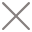

In [16]:
response = requests.get('https://www.unisoc.com/en_us/secy/announcementDetail/1676902764208259073', allow_redirects=False)
response.text

In [17]:
headers = {
   "User-Agent": "Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:15.0) Gecko/20100101 Firefox/15.0.1",
}

'<!doctype html>\n<html data-n-head-ssr>\n  <head >\n    <title>2023-07</title><base href="/en_us/"><link data-n-head="ssr" rel="icon" type="image/x-icon" href="/en_us/favicon.ico"><link rel="preload" href="/en_us/_nuxt/39bf4e3.js" as="script"><link rel="preload" href="/en_us/_nuxt/7130930.js" as="script"><link rel="preload" href="/en_us/_nuxt/css/ac11091.css" as="style"><link rel="preload" href="/en_us/_nuxt/f28d5e2.js" as="script"><link rel="preload" href="/en_us/_nuxt/css/4be427f.css" as="style"><link rel="preload" href="/en_us/_nuxt/0167afa.js" as="script"><link rel="preload" href="/en_us/_nuxt/css/c4009fc.css" as="style"><link rel="preload" href="/en_us/_nuxt/5f3cb76.js" as="script"><link rel="stylesheet" href="/en_us/_nuxt/css/ac11091.css"><link rel="stylesheet" href="/en_us/_nuxt/css/4be427f.css"><link rel="stylesheet" href="/en_us/_nuxt/css/c4009fc.css">\n  </head>\n  <body >\n    <div data-server-rendered="true" id="__nuxt"><!----><div id="__layout"><div class="app"><div data-
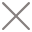

In [18]:
response = requests.get(url = 'https://www.unisoc.com/en_us/secy/announcementDetail/1676902764208259073', timeout=(4, 5), allow_redirects=False, headers=headers)
response.text

In [ ]:
with open('stuff.html', 'w+') as mf:
    mf.writelines(response.text)

In [ ]:
soup = BeautifulSoup(response.text, 'lxml')
soup.text

In [ ]:
htmltext = beautiful_request('https://www.unisoc.com/en_us/secy/announcementDetail/1676902764208259073')


In [ ]:
soup = BeautifulSoup(response.text, 'html.parser')
soup

In [ ]:
len(soup.text)

In [ ]:
test = '   **Vulnerability name:**  Exposure of secret in ALBIS\r'
remove_newlines(test)

In [ ]:
out = soup.prettify()

In [ ]:
htmltext = out.split('\n')
htmltext

In [ ]:
for i, line in enumerate(htmltext):
    if 'CVE-2023-30932' in line:
        print(i, line)
        break

In [ ]:
line

In [ ]:
# syz913/CVE-reports/blob/main/CVE-2023-31821.md
url = 'https://raw.githubusercontent.com/syz913/CVE-reports/main/CVE-2023-31821.md?raw=true'
response = requests.get(url = url, timeout=(4, 5), allow_redirects=False)
response.text
# https://github.com/syz913/CVE-reports/blob/main/CVE-2023-31821.md?raw=true

In [ ]:
url = 'https://github.com/syz913/CVE-reports/blob/main/CVE-2023-31821.md'
if 'github.com' in url:
    url += '?raw=true'
    response = requests.get(url = url, timeout=(4, 5), allow_redirects=True)
    print(response.text)